In [1]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
sample_data['Eddy790']['T0'].keys()

dict_keys(['U', 'V', 'x', 'y', 'z', 'VG', 'COW', 'LNAM', 'rho'])

In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

#### DOPPIO

In [4]:
def find_root(x, y, degree=3):
    """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
    coeffs = np.polyfit(x, y, degree)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid_x = x[len(x) // 2]
    return real_roots[np.argmin(np.abs(real_roots - mid_x))]

def tangent_at_root(x, y, root_x, degree=3):
    coeffs = np.polyfit(x, y, degree)
    slope = np.polyval(np.polyder(coeffs), root_x)
    intercept = np.polyval(coeffs, root_x) - slope * root_x
    y_fit = np.polyval(coeffs, x)
    r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
    return slope, intercept, r2

def doppio(nic, njc, u, v, X, Y, r):

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x

    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    return x0 + center_x, y0 + center_y, w


def VG_space(xi, yi, ui, vi):
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    
    return x0, y0, q11, q12, q22, w

In [5]:
df_DOPPIO = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U.shape[0]//2, U.shape[1]//2
        r = 5
        for depth_lvl in range(25):

            if not (r <= nic < U.shape[0] - r and r <= njc < U.shape[1] - r):
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
    
            xc, yc, w = doppio(nic, njc, u, v, X, Y, r)
            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if (R < 50) and (np.abs(w) >= 0.01):
                    df_DOPPIO.loc[len(df_DOPPIO)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break

In [7]:
df_DOPPIO

,Eddy,Day,xc,yc,nic,njc,z,Depth,w
0,Eddy790,0,7.133481,-0.581158,49,49,0,-1.783320,0.037167
1,Eddy790,0,6.372685,0.285363,51,49,1,-5.879627,0.036798
2,Eddy790,0,5.809128,0.756879,51,49,2,-10.725783,0.036525
3,Eddy790,0,5.197180,1.021586,51,49,3,-16.383097,0.036318
4,Eddy790,0,4.551339,1.080637,51,49,4,-22.925581,0.036093
...,...,...,...,...,...,...,...,...,...
2331,Eddy775,29,3.730977,-2.416898,51,48,11,-105.615538,-0.012985
2332,Eddy775,29,4.223554,-2.570736,50,48,12,-126.288127,-0.012553
2333,Eddy775,29,5.003580,-3.008361,50,48,13,-151.065954,-0.012086
2334,Eddy775,29,5.470478,-3.148775,51,48,14,-181.264793,-0.011323


Eddy775, t:13
Eddy775, t:16
Eddy775, t:19


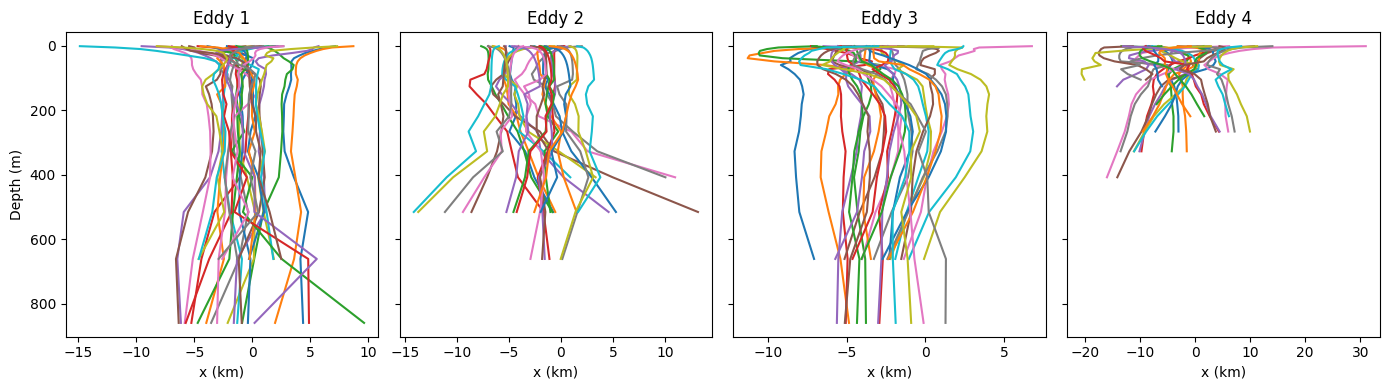

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_DOPPIO[(df_DOPPIO['Eddy']==eddy) & (df_DOPPIO['Day']==t)]
    
        axs[i].plot(df['xc'], -df['Depth'])
        axs[i].set_title(f'Eddy {i+1}')

        if len(df)==0:
            print(f'{eddy}, t:{t}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

In [9]:
df_VGspace = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U.shape[0]//2, U.shape[1]//2
        r = 5 #dx =5km
        for depth_lvl in range(25):

            if not (r <= nic < U.shape[0] - r and r <= njc < U.shape[1] - r):
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]

            mask = (np.hypot(X - X[nic, njc], Y - Y[nic, njc]) < r*dx).T
            xi, yi = X[mask], Y[mask]
            ui, vi = u.T[mask], v.T[mask]

            xc, yc, q11, q12, q22, w = VG_space(xi, yi, ui, vi)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50 and (np.abs(w) >= 0.01):
                    df_VGspace.loc[len(df_VGspace)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break

In [10]:
df_VGspace

,Eddy,Day,xc,yc,nic,njc,z,Depth,w
0,Eddy790,0,7.083044,-0.731358,49,49,0,-1.783320,0.036388
1,Eddy790,0,6.324005,0.655593,51,49,1,-5.879627,0.036655
2,Eddy790,0,5.789061,1.101772,51,49,2,-10.725783,0.036538
3,Eddy790,0,5.201934,1.328677,51,49,3,-16.383097,0.036441
4,Eddy790,0,4.562295,1.339110,51,49,4,-22.925581,0.036309
...,...,...,...,...,...,...,...,...,...
2336,Eddy775,29,4.723010,-2.872597,51,48,11,-105.615538,-0.013468
2337,Eddy775,29,5.050533,-2.924562,51,48,12,-126.288127,-0.012599
2338,Eddy775,29,5.603591,-3.323648,51,48,13,-151.065954,-0.012066
2339,Eddy775,29,5.971462,-3.479021,51,48,14,-181.264793,-0.011444


Eddy775, t:13


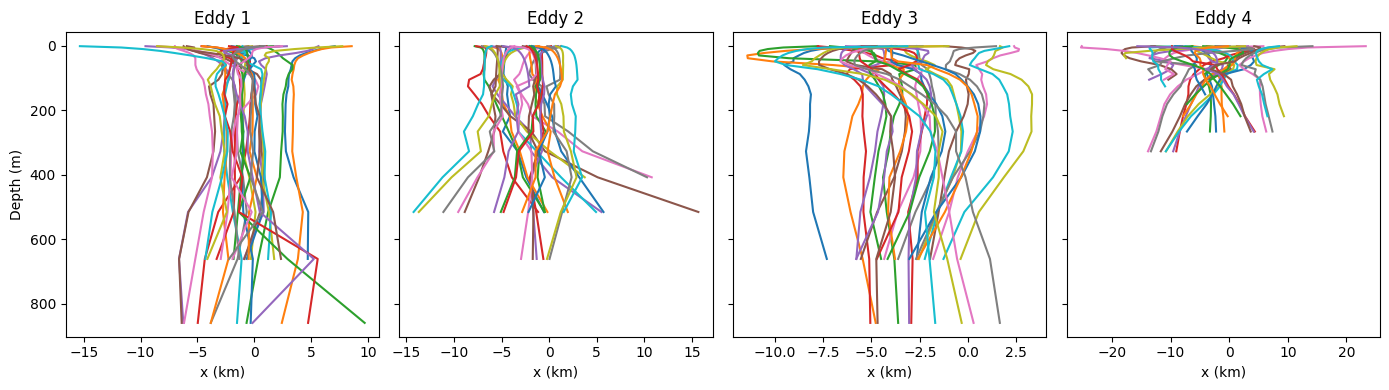

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_VGspace[(df_VGspace['Eddy']==eddy) & (df_VGspace['Day']==t)]
    
        axs[i].plot(df['xc'], -df['Depth'])
        axs[i].set_title(f'Eddy {i+1}')

        if len(df)==0:
            print(f'{eddy}, t:{t}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### COW

In [12]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

In [13]:
df_COW = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth', 'SR'])

CS_THRESH = 0.1
OW_THRESH = -.2
RATIO_THRESH = 1/3
SEARCH_RADIUS_MAX = 200

for eddy in the_frontier_eddies:

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]
        
        CS = np.hypot(U, V)
        OW = normalize_matrix(calc_ow(U, V, dx, dx))

        bottom_flag = 0
        xc_pre, yc_pre = 0, 0
        for depth_lvl in range(25):

            Search_Radius = 10

            if bottom_flag:
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            cs, ow = CS[:, :, depth_lvl], OW[:, :, depth_lvl]

            R = np.hypot(X - xc_pre , Y - yc_pre).T 

            while not bottom_flag:
                        
                    mask = (cs < CS_THRESH) & (ow < OW_THRESH) & (R < Search_Radius)
                    
                    potential_centers_ind = np.array(np.where(mask)).T
                    num_pot, num_search = np.sum(mask), np.sum(R < Search_Radius)
        
                    if num_pot == 0:
                        bottom_flag = 1
                        break
                        
                    ratio = num_pot / num_search
                    if ratio <= RATIO_THRESH:
                        A = np.array([[x[i], y[j]] for i, j in potential_centers_ind])
                        xc, yc = np.mean(A, axis=0)

                        R_diff = np.hypot(xc - xc_pre, yc - yc_pre)
                        if R_diff < 100:

                            df_COW.loc[len(df_COW)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'SR': Search_Radius}
                            xc_pre, yc_pre = xc, yc
                            break
                    
                    if Search_Radius >= SEARCH_RADIUS_MAX:
                        bottom_flag = 1
                    else:
                        Search_Radius += 5
        

In [14]:
df_COW

,Eddy,Day,xc,yc,z,Depth,SR
0,Eddy790,0,6.333333,-1.000000,0,-1.783320,10
1,Eddy790,0,6.272727,1.090909,1,-5.879627,10
2,Eddy790,0,6.000000,1.500000,2,-10.725783,10
3,Eddy790,0,5.454545,1.363636,3,-16.383097,10
4,Eddy790,0,4.500000,1.000000,4,-22.925581,15
...,...,...,...,...,...,...,...
2508,Eddy775,29,2.589744,-1.974359,15,-218.754856,35
2509,Eddy775,29,-1.008621,0.905172,16,-266.206398,35
2510,Eddy775,29,-3.670213,4.468085,17,-327.440851,30
2511,Eddy775,29,-5.240000,8.640000,18,-407.922192,30


Eddy134, t:16
Eddy134, t:19
Eddy134, t:28
Eddy775, t:13


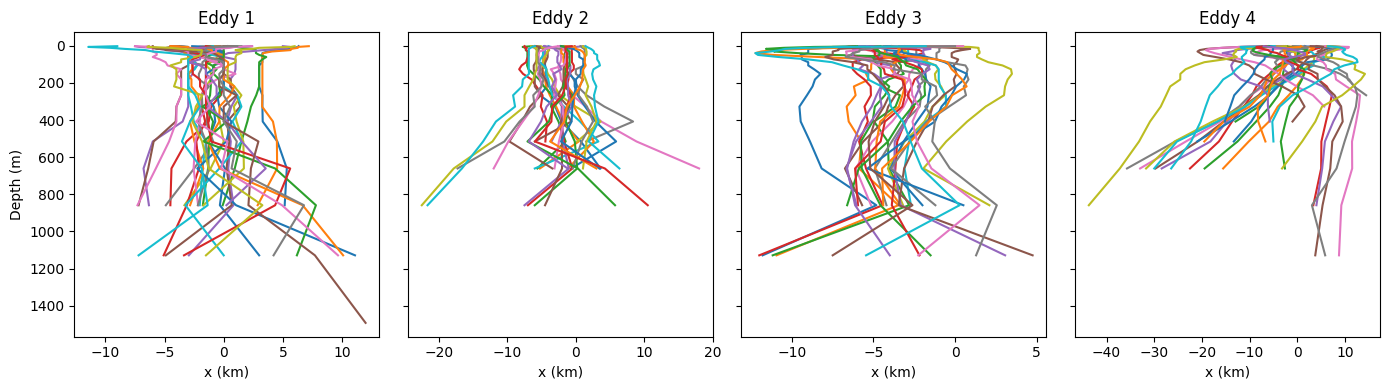

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_COW[(df_COW['Eddy']==eddy) & (df_COW['Day']==t)]

        if len(df)==0:
            print(f'{eddy}, t:{t}')
    
        axs[i].plot(df['xc'], -df['Depth'])
        axs[i].set_title(f'Eddy {i+1}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

#### LNAM

In [16]:
def calc_lnam(x, y, uu, vv): # remember to input u and v transpose
    b, f = 1, -1
    borders = b + 1
    # L = np.zeros_like(uu)
    L = np.full_like(uu, np.nan)
    for i in range(borders, uu.shape[0] - borders):
        for j in range(borders, uu.shape[1] - borders):
            if not np.isnan(vv[i, j]):
                xlocal = x[i - b:i + b + 1, j - b:j + b + 1]
                ylocal = y[i - b:i + b + 1, j - b:j + b + 1]
                ulocal = uu[i - b:i + b + 1, j - b:j + b + 1]
                vlocal = vv[i - b:i + b + 1, j - b:j + b + 1]
                center_idx = xlocal.shape[0]//2
                d_xcentre = xlocal - xlocal[center_idx, center_idx]
                d_ycentre = ylocal - ylocal[center_idx, center_idx]
                cross = d_xcentre * vlocal - d_ycentre * ulocal
                dot = ulocal * d_xcentre + vlocal * d_ycentre
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                if sumdp != 0:
                    L[i, j] = np.sum(cross) / sumdp * np.sign(f)
    return L


In [17]:
from scipy.ndimage import maximum_filter, minimum_filter

df_LNAM = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'z', 'Depth'])

WINDOW_SIZE = 7
SEARCH_RADIUS = 100
VAR = 1  # 1 for cyclonic

for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] < 0 else -1

    for t in range(30): 

        U = sample_data[eddy]['T'+str(t)]['U']
        V = sample_data[eddy]['T'+str(t)]['V']
        
        x, y = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

        sigma_OW = normalize_matrix(calc_ow(U, V, dx, dx))

        xc_pre, yc_pre = 0, 0
        ic_pre, jc_pre = U.shape[0] // 2, V.shape[1] // 2
        bottom_flag = False
        for depth_lvl in range(25):
            if bottom_flag:
                break

            u, v = U[:, :, depth_lvl], V[:,:, depth_lvl]
            
            IC, JC = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
            R = (np.hypot(ic_pre - IC, jc_pre - JC) * dx).T

            u = np.where(R <= SEARCH_RADIUS, u, np.nan)
            v = np.where(R <= SEARCH_RADIUS, v, np.nan)

            lnam = calc_lnam(X, Y, u.T, v.T).T

            if var == 1:
                extrema = maximum_filter(lnam, size=WINDOW_SIZE, mode='reflect')
            else:
                extrema = minimum_filter(lnam, size=WINDOW_SIZE, mode='reflect')

            positions = (lnam == extrema)
            ic, jc = np.argwhere(positions).T

            if len(ic):
                R = (np.hypot(ic - ic_pre, jc - jc_pre) * dx).T
                idx = np.nanargmin(R)
                ic, jc = ic[idx], jc[idx]

                R_diff = np.hypot(ic - ic_pre, jc - jc_pre) * dx
                if (sigma_OW[ic, jc, depth_lvl] <= -0.2) & (R_diff < 100):
                    df_LNAM.loc[len(df_LNAM)] = {'Eddy': eddy, 'Day': t, 'xc': x[ic], 'yc': y[jc], 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl]}
                    xc_pre, yc_pre = xc, yc
                    ic_pre, jc_pre = ic, jc
                else:
                    bottom_flag = True
        print(t)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [18]:
df_LNAM

,Eddy,Day,xc,yc,z,Depth
0,Eddy790,0,6.0,0.0,0,-1.783320
1,Eddy790,0,6.0,0.0,1,-5.879627
2,Eddy790,0,6.0,0.0,2,-10.725783
3,Eddy790,0,6.0,0.0,3,-16.383097
4,Eddy790,0,3.0,0.0,4,-22.925581
...,...,...,...,...,...,...
2504,Eddy775,29,6.0,-3.0,13,-151.065954
2505,Eddy775,29,6.0,-3.0,14,-181.264793
2506,Eddy775,29,6.0,-3.0,15,-218.754856
2507,Eddy775,29,6.0,-3.0,16,-266.206398


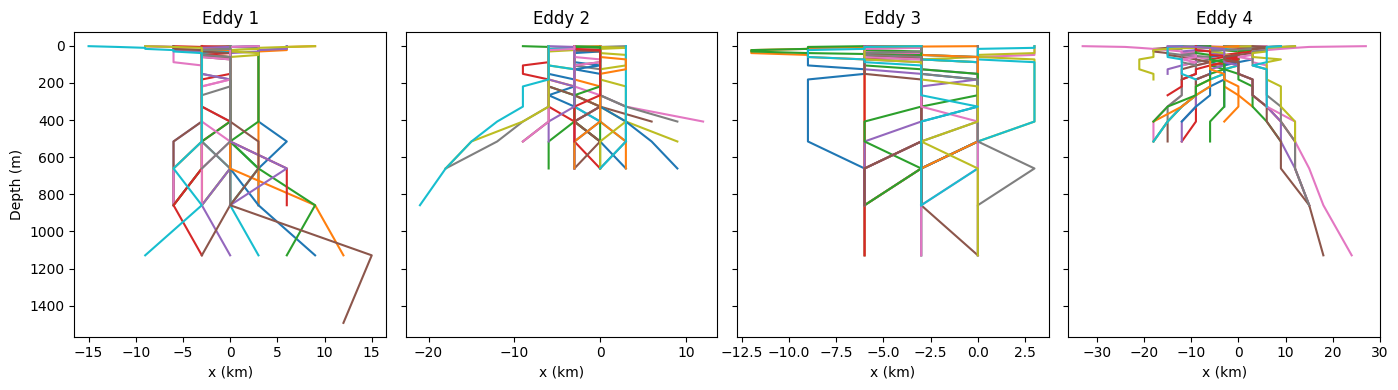

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_LNAM[(df_LNAM['Eddy']==eddy) & (df_LNAM['Day']==t)]

        if len(df)==0:
            print(f'{eddy}, t:{t}')
    
        axs[i].plot(df['xc'], -df['Depth'])
        axs[i].set_title(f'Eddy {i+1}')
    
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()

### Plotted all together

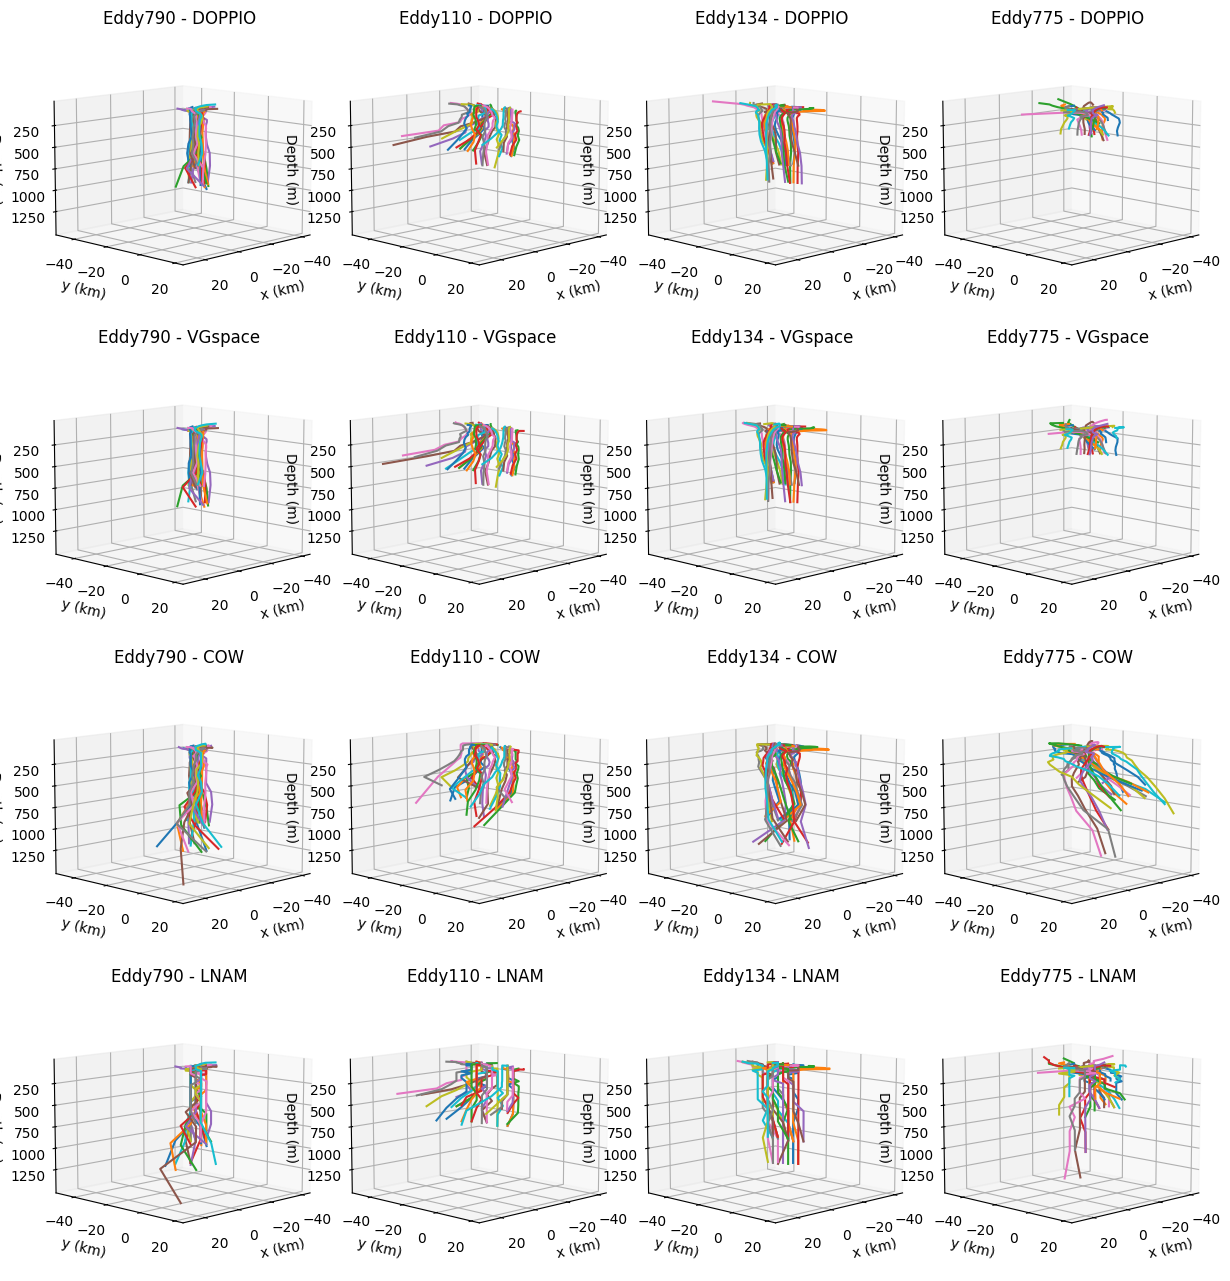

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(4, len(the_frontier_eddies), figsize=(12, 13), subplot_kw={'projection': '3d'})
methods = {'DOPPIO': df_DOPPIO, 'VGspace': df_VGspace, 'COW': df_COW, 'LNAM': df_LNAM}

# Compute column-wise limits
limits = {eddy: (
    min(df['xc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['xc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    min(df['yc'].min() for df in methods.values() if eddy in df['Eddy'].values),
    max(df['yc'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -max(df['Depth'].max() for df in methods.values() if eddy in df['Eddy'].values),
    -min(df['Depth'].min() for df in methods.values() if eddy in df['Eddy'].values),
) for eddy in the_frontier_eddies}

# Plot data
for r, (method, df_method) in enumerate(methods.items()):
    for c, eddy in enumerate(the_frontier_eddies):
        ax = axs[r, c]
        for t in range(30):
            df = df_method[(df_method['Eddy'] == eddy) & (df_method['Day'] == t)]
            ax.plot(df['xc'], df['yc'], -df['Depth'])

        ax.set(xlim=limits[eddy][:2], ylim=limits[eddy][2:4], zlim=limits[eddy][4:],
               xlabel="x (km)", ylabel="y (km)", zlabel="Depth (m)", title=f"{eddy} - {method}")
        ax.invert_zaxis()
        ax.view_init(elev=10, azim=45)

plt.tight_layout()
plt.show()


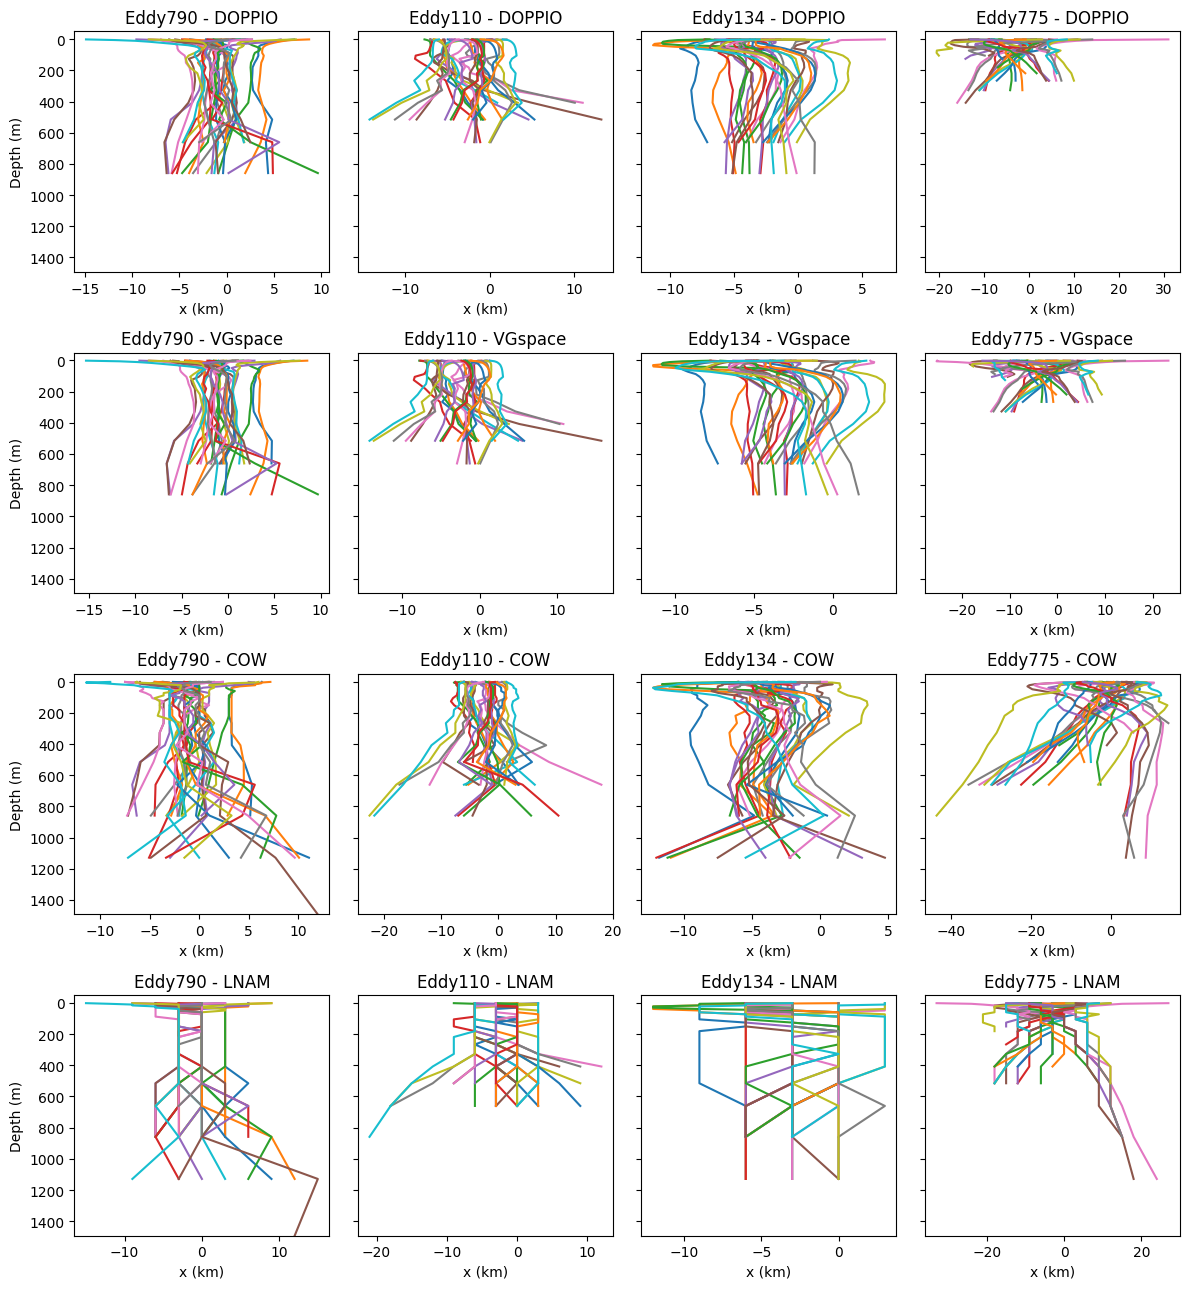

In [21]:
fig, axs = plt.subplots(4, len(the_frontier_eddies), figsize=(12, 13), sharey=True)
methods = {'DOPPIO': df_DOPPIO, 'VGspace': df_VGspace, 'COW': df_COW, 'LNAM': df_LNAM}

# Compute depth limits
depth_max = max(-df['Depth'].min() for df in methods.values())

# Plot data
for r, (method, df_method) in enumerate(methods.items()):
    for c, eddy in enumerate(the_frontier_eddies):
        ax = axs[r, c]
        for t in range(30):
            df = df_method[(df_method['Eddy'] == eddy) & (df_method['Day'] == t)]
            ax.plot(df['xc'], -df['Depth'])

        ax.set(xlabel="x (km)")
        if c == 0:
            ax.set(ylabel="Depth (m)")
        if r == 0:
            ax.set(title=f"{eddy}")

        ax.set_ylim(-50, depth_max)
        ax.set_title(f"{eddy} - {method}")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

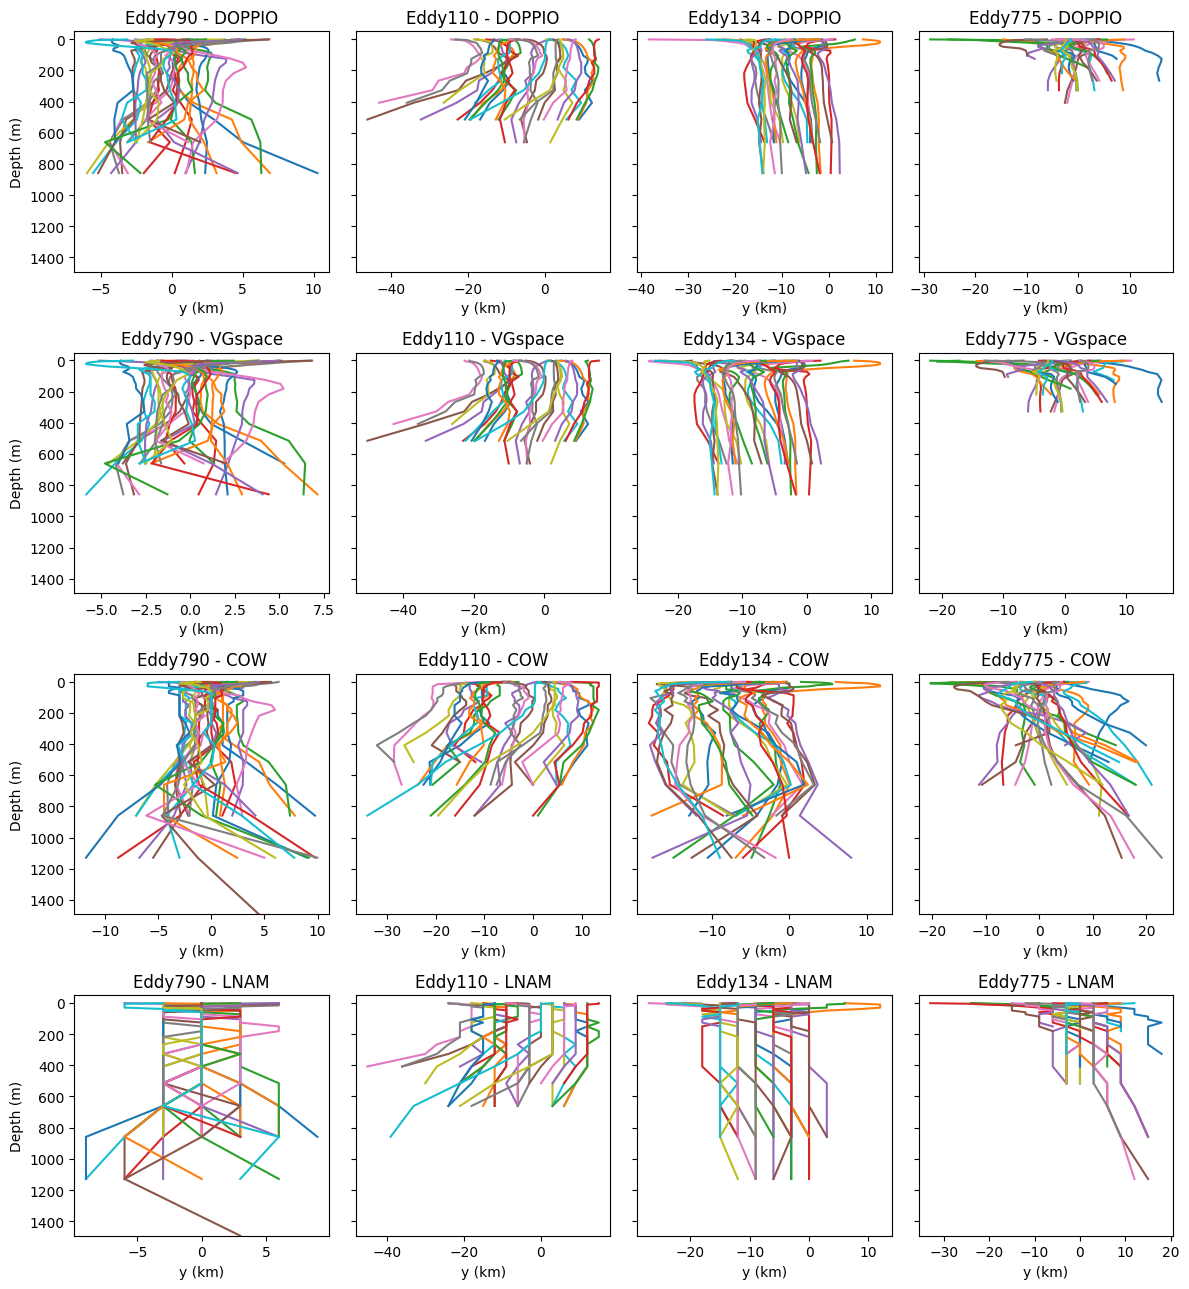

In [22]:
fig, axs = plt.subplots(4, len(the_frontier_eddies), figsize=(12, 13), sharey=True)
methods = {'DOPPIO': df_DOPPIO, 'VGspace': df_VGspace, 'COW': df_COW, 'LNAM': df_LNAM}

# Compute depth limits
depth_max = max(-df['Depth'].min() for df in methods.values())

# Plot data
for r, (method, df_method) in enumerate(methods.items()):
    for c, eddy in enumerate(the_frontier_eddies):
        ax = axs[r, c]
        for t in range(30):
            df = df_method[(df_method['Eddy'] == eddy) & (df_method['Day'] == t)]
            ax.plot(df['yc'], -df['Depth'])

        ax.set(xlabel="y (km)")
        if c == 0:
            ax.set(ylabel="Depth (m)")
        if r == 0:
            ax.set(title=f"{eddy}")

        ax.set_ylim(-50, depth_max)
        ax.set_title(f"{eddy} - {method}")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

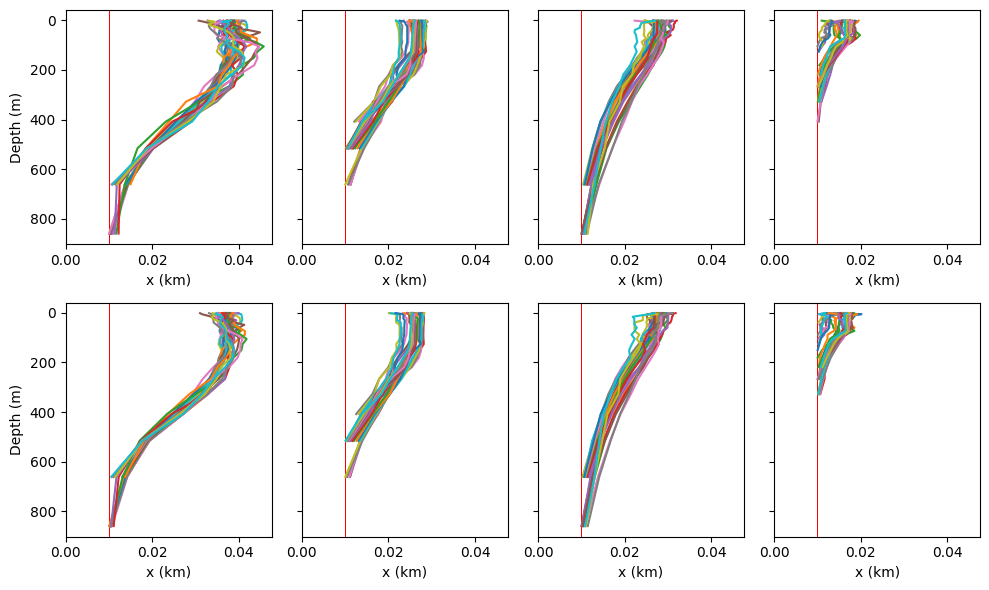

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6), sharey=True)

for e, eddy in enumerate(the_frontier_eddies):

    for t in range(30):
    
        df = df_DOPPIO[(df_DOPPIO['Eddy']==eddy) & (df_DOPPIO['Day']==t)]
        axs[0,e].plot(np.abs(df['w']), -df['Depth'])
        axs[0,e].axvline(x=0.01, color='r', zorder=-1, linewidth=.5, alpha=.5)

        df = df_VGspace[(df_VGspace['Eddy']==eddy) & (df_VGspace['Day']==t)]
        axs[1,e].plot(np.abs(df['w']), -df['Depth'])
        axs[1,e].axvline(x=0.01, color='r', zorder=-1, linewidth=.5, alpha=.5)
        
    axs[0, e].set_xlabel('x (km)')
    axs[1, e].set_xlabel('x (km)')

xmax = 0
for ax in axs.flat:
    xmax= max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(0, xmax)

    
axs[0,0].invert_yaxis()
axs[0,0].set_ylabel('Depth (m)')
axs[1,0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()